In [13]:
import tensorflow as tf
import os

# Specify the directory containing images
directory = "./Dataset_Trained/Side"

# Function to load and preprocess an image file
def check_image(file_path):
    try:
        image = tf.io.read_file(file_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
        return True
    except Exception as e:
        print(f"Error with file {file_path}: {e}")
        return False

# Iterate over all files in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        if not check_image(file_path):
            print(f"File causing issue: {file_path}")

print("Check complete!")


Check complete!


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_path = "./Dataset_Trained"

# Load training dataset
train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Load validation dataset
validation_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 2068 files belonging to 3 classes.
Using 1655 files for training.
Found 2068 files belonging to 3 classes.
Using 413 files for validation.


In [15]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt

# Assuming the validation dataset is already loaded
# validation_dataset is already defined as part of your training process

# Make predictions on the validation dataset
predictions = model.predict(validation_dataset)

# Get class names
class_names = validation_dataset.class_names

# Convert predictions to class labels
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_class_names = [class_names[i] for i in predicted_class_indices]

# Extract true labels
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
true_class_names = [class_names[i] for i in true_labels]

# Compare predictions with true labels
results = list(zip(predicted_class_names, true_class_names))

# Print results for all validation images
for pred, true in results:
    print(f"Predicted: {pred}, True: {true}")

In [ ]:
import os
import shutil
import numpy as np
from keras.models import load_model
from keras.preprocessing import image

# Define paths
input_folder = './downloaded_images'  # Folder containing images to classify
output_folder = './Dataset_Trained'  # Folder to save classified images

# Define category folders
categories = ['Front', 'Side', 'Angle']
for category in categories:
    os.makedirs(os.path.join(output_folder, category), exist_ok=True)

# Load the model

# Function to preprocess the image for classification
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Assuming the model was trained with normalized images
    return img_array

# Function to classify and move images
def classify_and_move_images(input_folder, output_folder):
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)
        if os.path.isfile(img_path):
            # Preprocess the image for classification
            img_array = preprocess_image(img_path)

            # Predict the class
            predictions = model.predict(img_array)
            predicted_class = categories[np.argmax(predictions)]

            # Copy the original image to the corresponding folder
            destination_folder = os.path.join(output_folder, predicted_class)
            shutil.copy(img_path, os.path.join(destination_folder, img_name))
            print(f'Copied {img_name} to {predicted_class}')

# Run the classification and move process
classify_and_move_images(input_folder, output_folder)


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50

# Load the datasets
dataset_path = "./Dataset_Trained"

train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Normalize the datasets
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

# Apply data augmentation to the training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

# Optionally, you can save the model after training
model.save('my_model.h5')


Found 2068 files belonging to 3 classes.
Using 1655 files for training.
Found 2068 files belonging to 3 classes.
Using 413 files for validation.
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3137 - loss: 1.2748 - val_accuracy: 0.3777 - val_loss: 1.1049
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.3679 - loss: 1.1018 - val_accuracy: 0.3729 - val_loss: 1.0944
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.3869 - loss: 1.0917 - val_accuracy: 0.3729 - val_loss: 1.0923
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.3793 - loss: 1.0979 - val_accuracy: 0.3729 - val_loss: 1.0947
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 954ms/step - accuracy: 0.3901 - loss: 1.0929 - val_accuracy: 0.3729 - val_loss: 1.0947
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 952ms/step - accuracy: 0.3978 - loss: 1.0921 - val_accuracy: 0.3729 - val_loss: 1.0941
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 960ms/step - accuracy: 0.3837 - loss: 1.0942 - val_

In [29]:
from fastai.vision.all import *


resize_images('./Dataset_Trained/Front', max_size=400, dest='./Dataset_FastAI/Front')
resize_images('./Dataset_Trained/Angle', max_size=400, dest='./Dataset_FastAI/Angle')
resize_images('./Dataset_Trained/Side', max_size=400, dest='./Dataset_FastAI/Side')

In [30]:
path = './Dataset_FastAI'

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

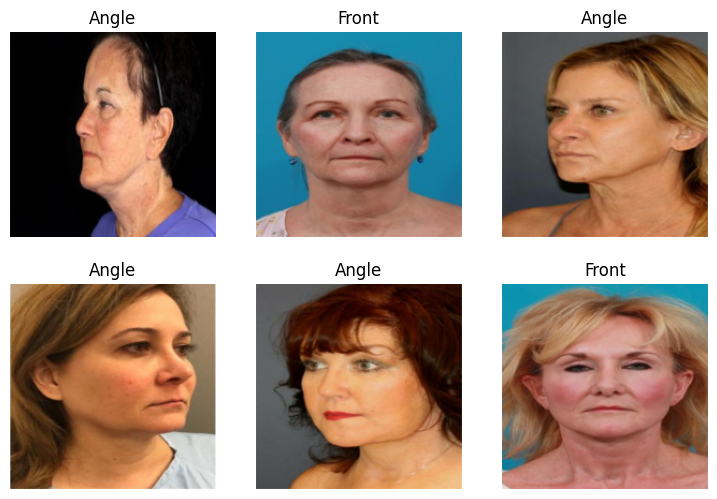

In [31]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [32]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [33]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.520011,0.100691,0.026634,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.152898,0.070306,0.012107,00:12
1,0.115569,0.093697,0.014528,00:13
2,0.081390,0.061804,0.004843,00:13
3,0.056931,0.079785,0.009685,00:13
4,0.031708,0.065232,0.007264,00:13


In [35]:
is_bird,_,probs = learn.predict(PILImage.create('angle_face.png'))
print(f"This is a: {is_bird}.")
print(f"Probability it's an Angle: {probs[0]:.4f}")


This is a: Angle.
Probability it's an Angle: 0.9999


In [36]:
pytorch_model = learn.model

In [ ]:
pytorch_model

In [39]:
batch = dls.one_batch()

# Extract the input shape from the batch
input_shape = batch[0].shape  # batch[0] contains the images

torch.Size([32, 3, 192, 192])

In [47]:
class_labels = dls.vocab
print(class_labels)

['Angle', 'Front', 'Side']


In [42]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [43]:
# Move the model to the determined device
pytorch_model = pytorch_model.to(device)

# Create a dummy input tensor with the shape of a single image and move it to the same device
dummy_input = torch.randn(1, input_shape[1], input_shape[2], input_shape[3], device=device)

# Export the model to ONNX format
torch.onnx.export(
    pytorch_model,               # Model to be exported
    dummy_input,                 # Dummy input tensor
    "model.onnx",                # Output file name
    export_params=True,          # Store the trained parameter weights inside the model file
    opset_version=11,            # ONNX version to export the model to
    do_constant_folding=True,    # Whether to execute constant folding for optimization
    input_names=['input'],       # Input names for the model
    output_names=['output'],     # Output names for the model
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Variable length axes
)

In [48]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Load the ONNX model
onnx_model_path = 'model.onnx'
ort_session = ort.InferenceSession(onnx_model_path)

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load an image and preprocess it
image_path = 'angle_face.png'
image = Image.open(image_path).convert('RGB')  # Convert to RGB
image = transform(image).unsqueeze(0)  # Add batch dimension

# Convert the image to a NumPy array
input_data = image.numpy()

# Run inference
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

result = ort_session.run([output_name], {input_name: input_data})

# Process the result
predictions = result[0]
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {class_labels[predicted_class]}')

Predicted class: ['Angle']
